In [1]:
import numpy as np 
import requests
import glob
import os
import shutil
import pprint
import json
import pandas as pd 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import helper
import matplotlib.pyplot as plt
import IPython.display as ipd
import seaborn as sns
import torch.optim as optim

import warnings
import os
warnings.filterwarnings('ignore')

from torch import nn, optim
from torchvision import transforms, models, datasets
from io import BytesIO
from fastai.callbacks import *
from sklearn.metrics import roc_curve, auc
from fastai.vision import *
sns.set(style='whitegrid')
plt.style.use('seaborn-darkgrid')


print(os.listdir("../input"))



['chest_xray']


In [2]:
path = Path('../input/chest_xray/chest_xray/')
np.random.seed(42)

data = ImageDataBunch.from_folder(path, train='train', valid_pct=0.2, test='test',ds_tfms=get_transforms(),size=224, bs=128, num_workers=5).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (4685 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: ../input/chest_xray/chest_xray;

Valid: LabelList (1171 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,NORMAL,NORMAL,NORMAL
Path: ../input/chest_xray/chest_xray;

Test: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: ../input/chest_xray/chest_xray

In [3]:
#data.classes, data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds)

In [4]:
#data.show_batch(4, figsize=(15,10))

In [5]:
learn = create_cnn(data, models.resnet34, path='.', metrics=[accuracy,error_rate], opt_func=optim.SGD)
learn.loss_func = nn.CrossEntropyLoss()


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 104642833.84it/s]


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.646002,0.501562,0.784799,0.215201,04:11
1,0.372706,0.169740,0.944492,0.055508,04:12
2,0.255718,0.150485,0.948762,0.051238,04:10
3,0.199598,0.161665,0.944492,0.055508,04:10
4,0.162513,0.143625,0.959009,0.040991,04:11
5,0.137448,0.154639,0.950470,0.049530,04:11
6,0.127000,0.166281,0.945346,0.054654,04:12
7,0.120115,0.154371,0.947908,0.052092,04:18


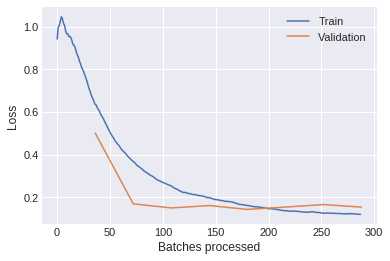

In [6]:
learn.fit_one_cycle(8, 1e-2)
learn.recorder.plot_losses()
plt.show()

In [7]:
learn.save('train_1', return_path=True)

PosixPath('models/train_1.pth')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
6.309573444801933e-07


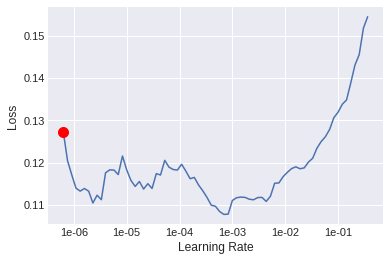

In [8]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
Learning_rate = learn.recorder.min_grad_lr
print(Learning_rate)
plt.show()

In [9]:
learn.fit_one_cycle(3, Learning_rate)
plt.show()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.119855,0.160599,0.947908,0.052092,04:10
1,0.117628,0.159833,0.947908,0.052092,04:08
2,0.116476,0.157716,0.947908,0.052092,04:09


In [10]:
learn.load('train_1')

Learner(data=ImageDataBunch;

Train: LabelList (4685 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: ../input/chest_xray/chest_xray;

Valid: LabelList (1171 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,NORMAL,NORMAL,NORMAL
Path: ../input/chest_xray/chest_xray;

Test: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: ../input/chest_xray/chest_xray, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilati

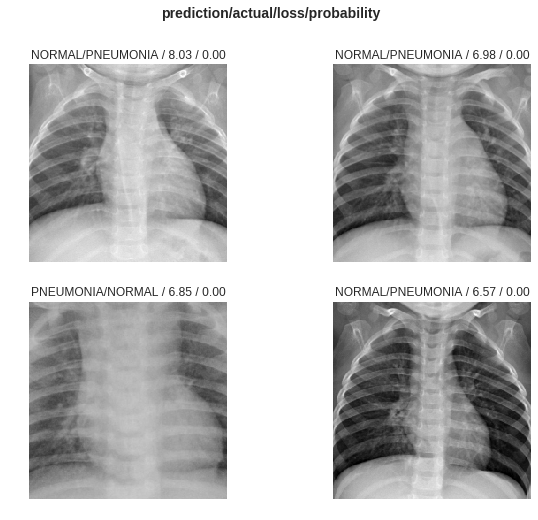

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(4, figsize=(10,8), heatmap=False)
plt.show()

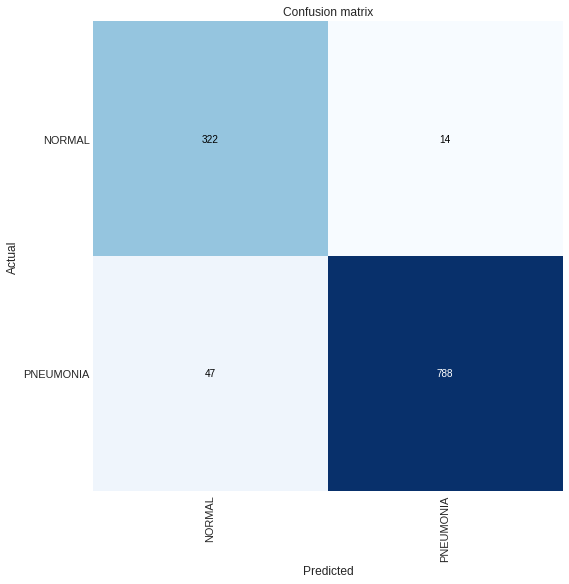

[('PNEUMONIA', 'NORMAL', 47), ('NORMAL', 'PNEUMONIA', 14)]

In [12]:
interp.plot_confusion_matrix(figsize=(10, 8))
plt.show()
interp.most_confused()

In [13]:
#preds,_ = learn.get_preds(ds_type=DatasetType.Test)

In [14]:
log_preds,y = learn.TTA(ds_type=DatasetType.Test)
accuracy(log_preds, y)

tensor(0.2388)

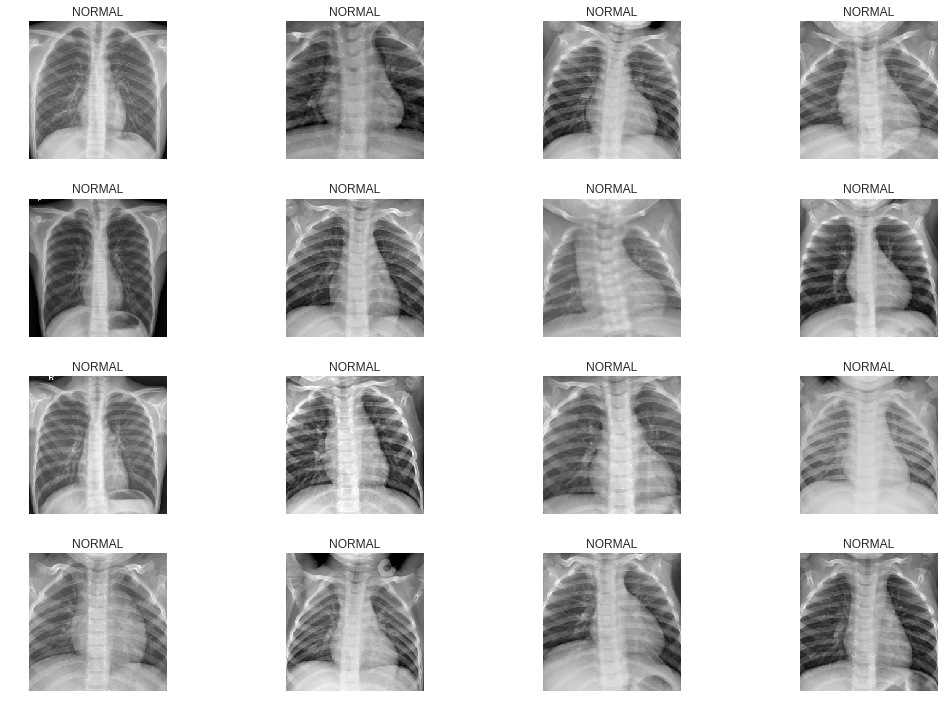

In [15]:
data.show_batch(4, ds_type=DatasetType.Test,figsize=(15,10))

In [16]:
preds, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)
y = torch.argmax(preds, dim=1)

(Category NORMAL, tensor(0), tensor([9.9997e-01, 3.3946e-05]))

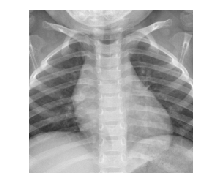

In [17]:
img = data.test_ds[3][0]
show_image(img)
learn.predict(img)

In [18]:
preds_test_tta,y_test_tta=learn.TTA(ds_type=DatasetType.Test)

In [19]:

path = Path('../input/chest_xray/chest_xray/')

test_data = ImageDataBunch.from_folder(path, test='test', ds_tfms=get_transforms(),size=224, bs=64).normalize(imagenet_stats)


In [20]:
test_data

ImageDataBunch;

Train: LabelList (5216 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: ../input/chest_xray/chest_xray;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ../input/chest_xray/chest_xray;

Test: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: ../input/chest_xray/chest_xray

In [21]:
preds,_ = learn.get_preds()


In [22]:
test_url = 'https://stanfordmlgroup.github.io/projects/chexnet/img/chest-example2.png'
def fetch_image(url):
    response = requests.get(url)
    img = open_image(BytesIO(response.content))
    return img

In [23]:
img = fetch_image(test_url)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class , pred_idx, outputs

(Category NORMAL, tensor(0), tensor([0.8239, 0.1761]))

In [24]:
def predict(url):
    img = fetch_image(url)
    pred_class,pred_idx,outputs = learn.predict(img)
    res =  zip (learn.data.classes, outputs.tolist())
    predictions = sorted(res, key=lambda x:x[1], reverse=True)
    top_predictions = predictions[0:2]
    pprint.pprint( top_predictions)
    return img.resize(500)

[('NORMAL', 0.8238832354545593), ('PNEUMONIA', 0.1761167049407959)]


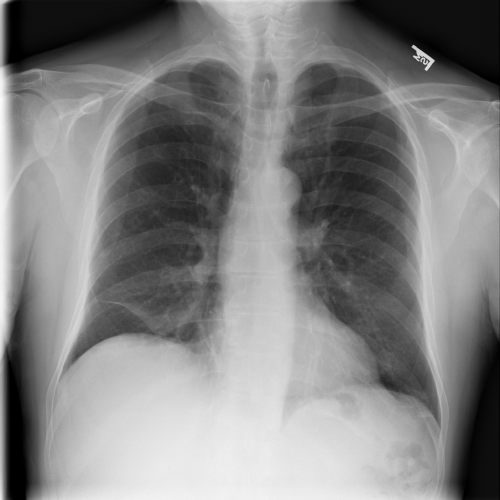

In [25]:
predict(test_url)

In [26]:
learn.export()

In [27]:
learn.export('train_1.pkl')

In [28]:
path = learn.path
path

PosixPath('.')

In [29]:
learn = load_learner(path)

In [30]:
learn = load_learner(path, 'train_1.pkl')